## To Run in Google Colab

In [1]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

# List MyDrive before t
!ls /content/drive/MyDrive/



# Open dataset from zipfile
zip_path = "/content/drive/MyDrive/flowers.zip"
extract_path = '/content/drive/MyDrive/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



# lists all files in Google Drive
!ls /content/drive/MyDrive/

Mounted at /content/drive
 CNN_AutoEncoder.ipynb	        flowers.zip				    WGAN.ipynb
 CNNS_Transfer_Learning.ipynb  'MultiLayer_Perceptron_(MLP) -Model.ipynb'
 Custom_MLP_Model.ipynb         VAE.ipynb
Dataset unzipped successfully!
 CNN_AutoEncoder.ipynb	        flowers_train_validation		    VAE.ipynb
 CNNS_Transfer_Learning.ipynb   flowers.zip				    WGAN.ipynb
 Custom_MLP_Model.ipynb        'MultiLayer_Perceptron_(MLP) -Model.ipynb'


## Run on Local Machine

In [2]:
'''

import os
import zipfile

# Define the paths for the zip file and extraction directory
zip_path = r"C:\path\to\your\flowers.zip"  # Update this to your zip file's actual path
extract_path = r"C:\path\to\extract\directory"  # Update this to your desired extraction directory

# Ensure the extraction path exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully!")
except FileNotFoundError:
    print(f"Error: The file {zip_path} does not exist.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_path} is not a valid zip file.")

'''


'\n\nimport os\nimport zipfile\n\n# Define the paths for the zip file and extraction directory\nzip_path = r"C:\\path\to\\your\x0clowers.zip"  # Update this to your zip file\'s actual path\nextract_path = r"C:\\path\to\\extract\\directory"  # Update this to your desired extraction directory\n\n# Ensure the extraction path exists\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract the zip file\ntry:\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n    print("Dataset unzipped successfully!")\nexcept FileNotFoundError:\n    print(f"Error: The file {zip_path} does not exist.")\nexcept zipfile.BadZipFile:\n    print(f"Error: The file {zip_path} is not a valid zip file.")\n\n'

# Flower Classification Using CNN and Transfer Learning
I Built a  CNN Model using Keras to classify images of flowers, visualize intermediate representations and use transfer learning to improve prediction accuracy.

In [3]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Google CoLab
train_dir  = '/content/drive/MyDrive/flowers_train_validation/train'
validation_dir = '/content/drive/MyDrive/flowers_train_validation/validation'

# Local Machine
#Train = 'C:/path to local drive for extracted files /flowers_train_validation/train'
#Validation = 'C:/path to local drive for extracted files /flowers_train_validation/validation'
TARGET_SIZE=(150,150)

## 1. CNN Model on Flower Prediction

### 1.1: Data Preparation and Augmentation
I use the ImageDataGenerator class to augment our training data and rescale the images. Data augmentation helps in increasing the diversity of the training data, which helps in reducing overfitting.

In [5]:
# Create ImageDataGenerators for training and validation data
# The train_datagen is used for augmenting the training data with various transformations.
# The validation_datagen is only rescaled, as no augmentation is needed.

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the target directory
    target_size=TARGET_SIZE,  # All images will be resized to 150x150
    batch_size=32,
    class_mode='categorical'  # Since we use binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode='categorical'
)

Found 3458 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [7]:
# Get the original image shape
original_image_shape = train_generator.image_shape
print("Original image shape:", original_image_shape)

Original image shape: (150, 150, 3)


### 1.2: Building the CNN Model

I will build the CNN model using Keras' Sequential API. I'll start by adding convolutional layers followed by max-pooling layers.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

#build model
input_layer = layers.Input((150,150,3))

x = layers.Conv2D(32, (3, 3), padding = "valid", activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3),padding = "valid", activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
output_layer = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0     

### Compiling the Model
The model is compiled using the Adam optimizer and categorical crossentropy loss, which is suitable for multi-class classification problems.

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 1.4: Training the Model
We train the model using the training data, and validate it using the validation data to monitor its performance and avoid overfitting.

In [10]:
# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
109/109 [==============================] - 32s 284ms/step - loss: 2.1908 - accuracy: 0.3586 - val_loss: 1.3249 - val_accuracy: 0.4705
Epoch 2/10
109/109 [==============================] - 31s 283ms/step - loss: 1.2994 - accuracy: 0.4905 - val_loss: 1.3851 - val_accuracy: 0.5098
Epoch 3/10
109/109 [==============================] - 31s 285ms/step - loss: 1.2189 - accuracy: 0.5263 - val_loss: 1.4081 - val_accuracy: 0.5145
Epoch 4/10
109/109 [==============================] - 31s 284ms/step - loss: 1.1133 - accuracy: 0.5495 - val_loss: 1.1189 - val_accuracy: 0.5595
Epoch 5/10
109/109 [==============================] - 31s 285ms/step - loss: 1.0809 - accuracy: 0.5697 - val_loss: 1.0456 - val_accuracy: 0.5827
Epoch 6/10
109/109 [==============================] - 31s 280ms/step - loss: 1.0105 - accuracy: 0.6073 - val_loss: 1.0637 - val_accuracy: 0.6081
Epoch 7/10
109/109 [==============================] - 31s 285ms/step - loss: 1.0076 - accuracy: 0.6024 - val_loss: 0.9182 - val_ac

### 1.5: Plot train/valiation loss and accuracy

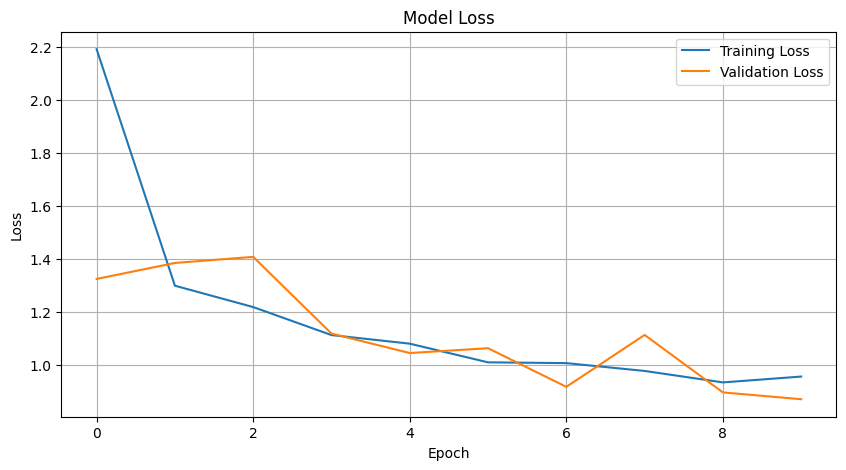

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

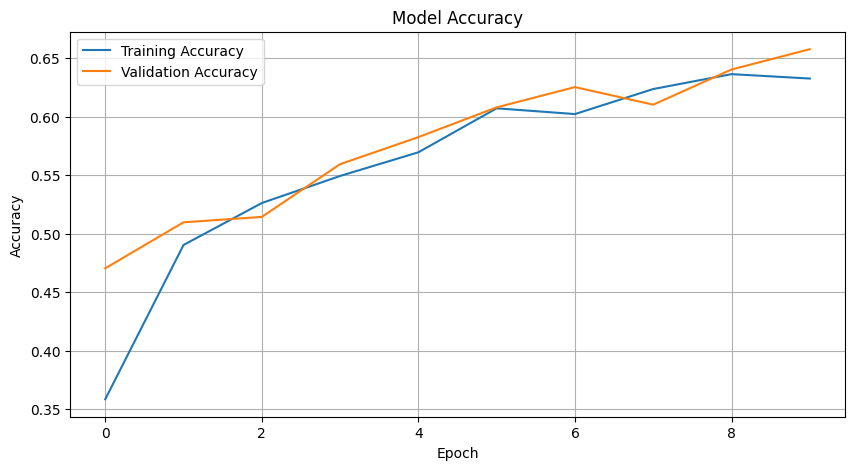

In [12]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

### 1.6: Comparing predicted classes and actual classes

#### 1.6.1 Extract class names

In [13]:
import os
import numpy as np

'''
Given an data_path that is the folder that contains the folder names, and the folder name are the class names
return the list of class names, stored in np.array (not a list)
'''
def get_classes(data_path):
    CLASSES = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
    CLASSES = np.array(CLASSES)
    return (CLASSES)

CLASSES = get_classes(train_dir)
print(CLASSES)

['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


### 1.6.2 Predict the first batch of validation

In [14]:
# Access the first batch of images (x_test) and labels (y_test)
x_test, y_test = validation_generator[0]  # Access the first batch
print("The first batch shapes: ", x_test.shape, y_test.shape)

The first batch shapes:  (32, 150, 150, 3) (32, 5)


In [15]:
preds = model.predict(x_test)
preds= CLASSES[np.argmax(preds, axis=-1)]
actual = CLASSES[np.argmax(y_test, axis=-1)]

print("The first 10 predicted classes: ", preds[:10])
print("The first 10 actual classes: ", actual[:10])

1/1 [==============================] - 0s 91ms/step
The first 10 predicted classes:  ['dandelion' 'tulip' 'rose' 'tulip' 'dandelion' 'dandelion' 'sunflower'
 'daisy' 'sunflower' 'dandelion']
The first 10 actual classes:  ['dandelion' 'rose' 'rose' 'tulip' 'dandelion' 'dandelion' 'dandelion'
 'daisy' 'sunflower' 'dandelion']


### Compare predicted and actual class

In [16]:
def pred_act_visualization(num, x_test, preds, actuals):
    """
    Visualize the predictions and actual labels of a set of images.

    Parameters:
    - num: Number of images to display.
    - x_test: Array of test images.
    - preds: Array of predicted labels.
    - actuals: Array of actual labels.
    """

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(num):
        img = x_test[i]
        ax = fig.add_subplot(1, num, i + 1)
        ax.axis("off")
        ax.text(
            0.5,
            -0.35,
            "pred = " + str(preds[i]),
            fontsize=10,
            ha="center",
            transform=ax.transAxes,
        )
        ax.text(
            0.5,
            -0.7,
            "act = " + str(actuals[i]),
            fontsize=10,
            ha="center",
            transform=ax.transAxes,
        )
        ax.imshow(img)


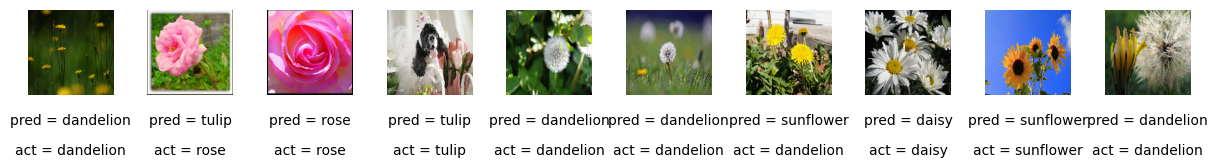

In [17]:
pred_act_visualization(10, x_test, preds, actual)

## 2. Visualizing Intermediate Representations

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Visualizing Intermediate Representations

In [19]:
# Define visualization model
def define_visualization_model(model):
  Successive_outputs = [layer.output for layer in model.layers[1:]]
  visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = Successive_outputs)
  return visualization_model

In [20]:
# Preprocess an input image
def preprocess_image(x):
    x /= 255
    return x

In [21]:
# Generate feature maps
def generate_feature_maps(visualization_model, x):
    successive_feature_map = visualization_model.predict(x)
    return successive_feature_map

In [22]:
# Normalize and scale feature map slice
def normalize_feature_map(feature_map_slice):
    x = feature_map_slice
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [23]:
# Visualize feature maps
def visualize_feature_maps(model, successive_feature_maps):
    layer_names = [layer.name for layer in model.layers[1:]]
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
      if(len(feature_map.shape) == 4):
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
          x = feature_map[0, :, :, i]
          x = normalize_feature_map(x)
          display_grid[:, i * size : (i + 1) * size] = x

        scale = 20/n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [24]:
# Main process
def main_visualization_process(model, x):
    visualization_model = define_visualization_model(model)
    x = preprocess_image(x)
    successive_feature_maps = generate_feature_maps(visualization_model, x)
    visualize_feature_maps(model, successive_feature_maps)

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def prepare_image(data_dir, image_file, target_size=TARGET_SIZE):
    """
    Prepares an image from a given directory by loading it, converting it to an array,
    normalizing it, and reshaping it to match the expected input format of a model.

    Parameters:
    - data_dir: The directory where the image is stored.
    - image_file: The name of the image file (e.g., 'image_file.png').
    - target_size: The target size for the image (default is (150, 150)).

    Returns:
    - x: Numpy array with shape (1, target_size[0], target_size[1], 3).
    """
    # Construct the full image path
    img_path = os.path.join(data_dir, image_file)
    print(f"Image path: {img_path}")

    # Load the image with the specified target size
    img = load_img(img_path, target_size=target_size)

    # Convert the image to a numpy array
    x = img_to_array(img)

    # Reshape the array to add an extra dimension (batch size of 1)
    x = x.reshape((1,) + x.shape)  # Shape becomes (1, 150, 150, 3)

    return x

### Visualizing Intermediate Representations

Image path: /content/drive/MyDrive/flowers_train_validation/validation/tulip/tulip_000524.png
1/1 [==============================] - 0s 92ms/step


<ipython-input-22-f520ec994eb8>:5: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-22-f520ec994eb8>:8: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


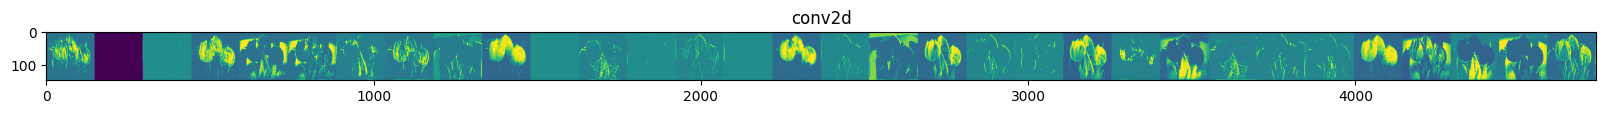

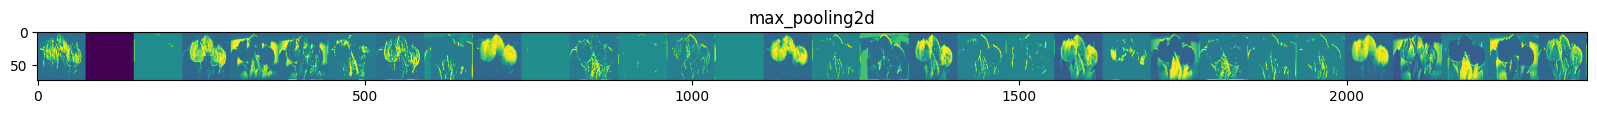

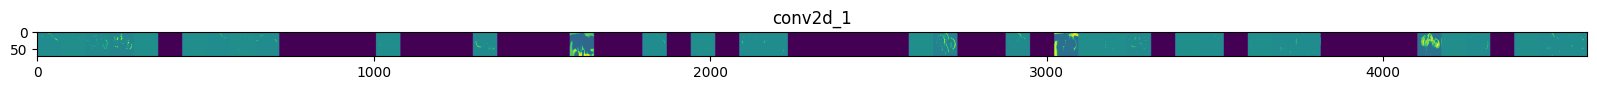

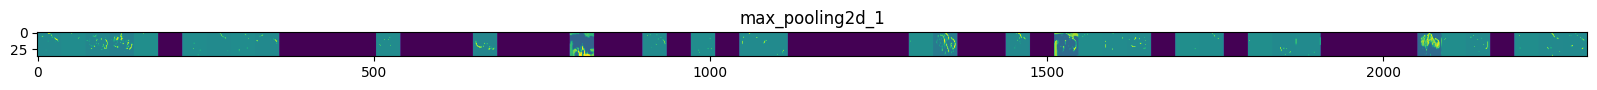

In [26]:
#####################################################################
# test case 1: tulip image
#####################################################################

tulip = prepare_image(validation_dir, "tulip/tulip_000524.png", (150,150))
main_visualization_process(model,tulip)

Image path: /content/drive/MyDrive/flowers_train_validation/validation/rose/rose_000231.png
1/1 [==============================] - 0s 52ms/step


<ipython-input-22-f520ec994eb8>:5: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-22-f520ec994eb8>:8: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


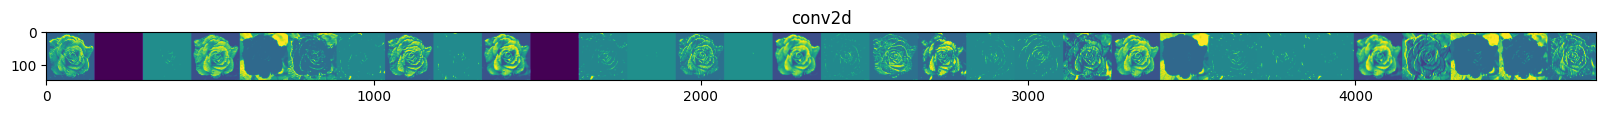

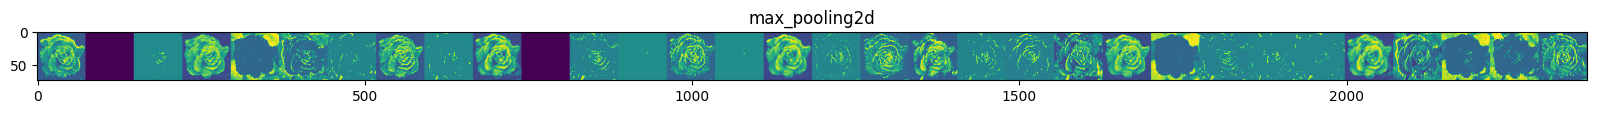

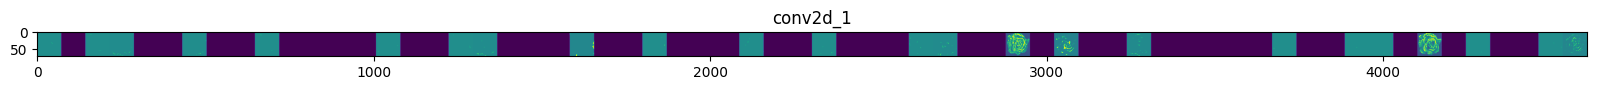

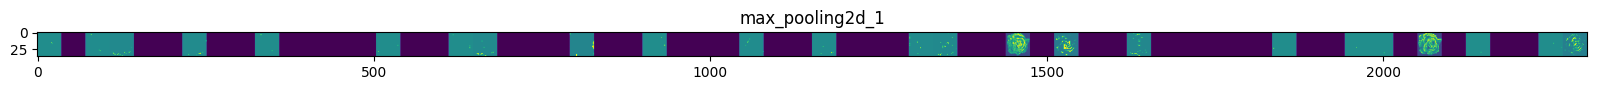

In [27]:
#####################################################################
# test case 2: rose image
#####################################################################
rose = prepare_image(validation_dir, "rose/rose_000231.png", (150,150))
main_visualization_process(model, rose)

Image path: /content/drive/MyDrive/flowers_train_validation/validation/daisy/daisy_000182.png
1/1 [==============================] - 0s 53ms/step


<ipython-input-22-f520ec994eb8>:5: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-22-f520ec994eb8>:8: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


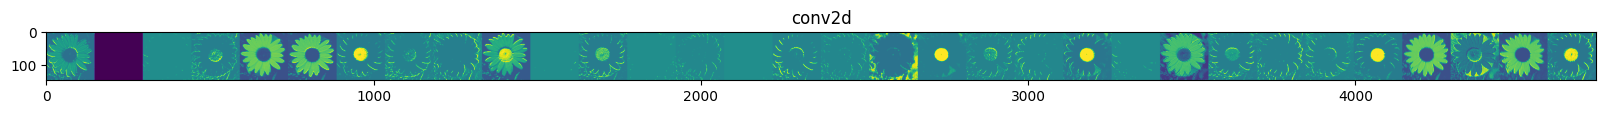

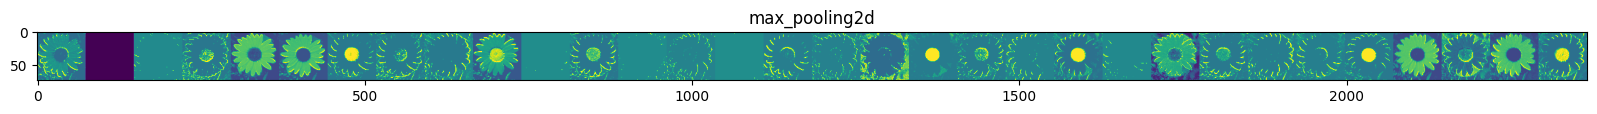

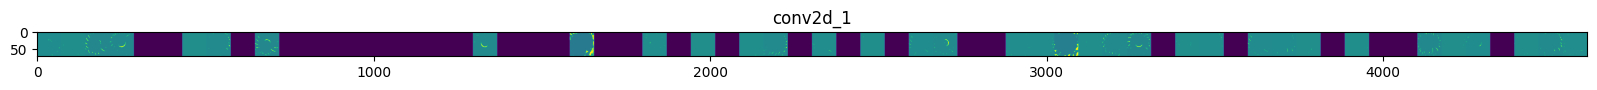

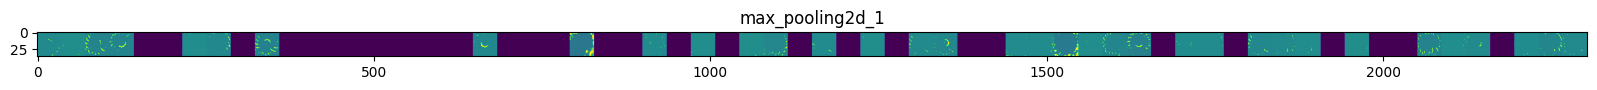

In [28]:
#####################################################################
# test case 3: daisy image
#####################################################################
daisy = prepare_image(validation_dir, "daisy/daisy_000182.png", (150,150))
main_visualization_process(model, daisy)

## 3. Transfer Learning

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

###Building the Transfer Learning based CNN Model

In [30]:
#####################################################################
# Building my model
#####################################################################

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))

for layer in base_model.layers:
  layer.trainable = False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(5, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
transfer_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [32]:
# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model using dataset

transfer_history = transfer_model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
109/109 [==============================] - 65s 589ms/step - loss: 1.4639 - accuracy: 0.3670 - val_loss: 1.2539 - val_accuracy: 0.5827
Epoch 2/10
109/109 [==============================] - 64s 586ms/step - loss: 1.1953 - accuracy: 0.5503 - val_loss: 1.0909 - val_accuracy: 0.6046
Epoch 3/10
109/109 [==============================] - 64s 586ms/step - loss: 1.0531 - accuracy: 0.6113 - val_loss: 0.9850 - val_accuracy: 0.6462
Epoch 4/10
109/109 [==============================] - 64s 585ms/step - loss: 0.9680 - accuracy: 0.6498 - val_loss: 0.9083 - val_accuracy: 0.6913
Epoch 5/10
109/109 [==============================] - 64s 587ms/step - loss: 0.9173 - accuracy: 0.6747 - val_loss: 0.8735 - val_accuracy: 0.6902
Epoch 6/10
109/109 [==============================] - 65s 592ms/step - loss: 0.8655 - accuracy: 0.6964 - val_loss: 0.8463 - val_accuracy: 0.6936
Epoch 7/10
109/109 [==============================] - 65s 594ms/step - loss: 0.8458 - accuracy: 0.6923 - val_loss: 0.8039 - val_ac

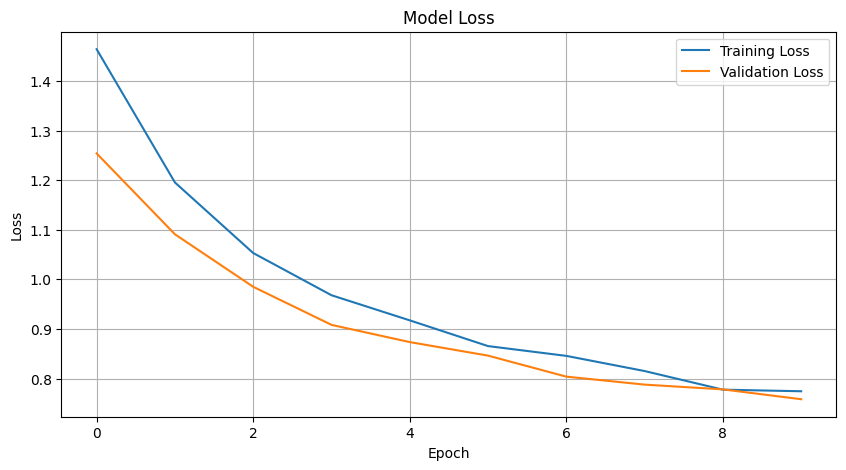

In [34]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


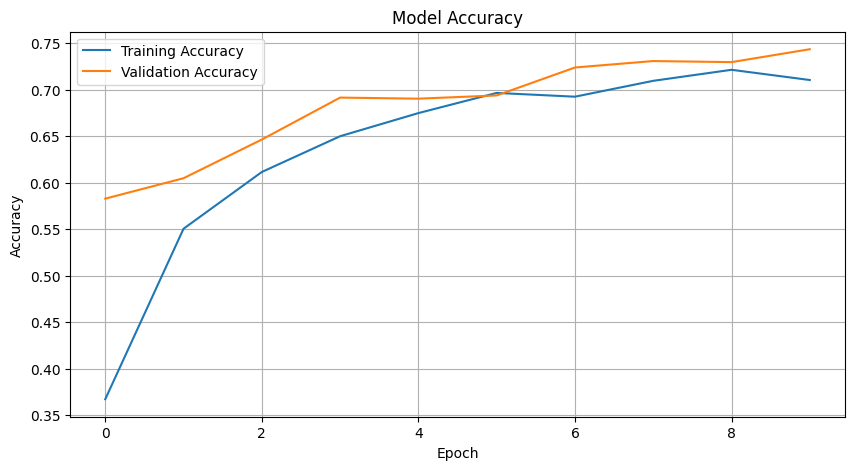

In [35]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()